# Deep Image Prior for Denoising

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from dip.utils import load_image, add_noise, plot_image, plot_images
from dip.models import DIPNet

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

seed = 41
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

cpu


## Model Definition and Training

Below are the hyperparameters used by Ulyanov et al. for the task of denoising.
- `z` is the input tensor to the network, consisting of uniform random noise between 0 and 0.1
- `n` represents channels counts
- `k` represents kernel dimensions
- `u`, `d`, and `s` subscripts represent the upsampling (decoder), downsampling (encoder), and skip connection layers respectively.
- $\sigma _p$ represents the standard deviation of the random perturbations of input tensor
- `num_iter` is the number of training iterations
- `LR` is the learning rate
- `upsampling` describes the upsampling method, either bilinera interpolation or nearest neighbor

![Hyperparameters](figures/reference_hyperparameters.png)

We found that in order to most effectively achieve good performance at denoising, the following hyperparameters were best. The differences with the authors hyperparameters are:
- A constant number of channels at each layer, as opposed to increasing channels with increasing depth. The increased number of feature maps and parameters allowed the network to more effectively learn the target image.
- The last skip connection layer is removed. The output of the decode is passed to the encoder without any intermediate convolutions. This is very minor change, as despite the authors notation, the last skip connection is not a true skip connection (as it does not pass any inputs across another layer.
- Training with 10,000 iterations (equivalent to epochs given the batchsize is 1) allows for fuller image reconstruction. The required iterations differs depending on the image, but 10,000 iterations allowed for convergence on all images we tested. Monitoring and stopping is required, as many images will show reconstruction of noise later in training.

In [3]:
# Hyperparameters
w = 512
h = w
z_shape, u_range = (1, 3, w, h), (0, 0.1)
nu = nd = [128, 128, 128, 128, 128]
ku = kd = [3, 3, 3, 3, 3]
ns = [0, 0, 0, 4, 0]
ks = [1, 1, 1, 1, 1]
sigma_p = 1 / 30
epochs = 10000
lr = 0.01
upsampling = 'bilinear'

In [4]:
loss_function = nn.MSELoss()
# Dataframe to store the loss at every iteration
loss_df = pd.DataFrame()

# Training function
def train(image, show_intermediates=False, show_final=False, show_loss=True, logging_name=None, show_every=1000):
    model = DIPNet(nd=nd, kd=kd, nu=nu, ku=ku, ns=ns, ks=ks, d_in=z_shape, upsampling=upsampling).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Initialize randome noise input tensor
    z = torch.rand(z_shape).uniform_(u_range[0], u_range[1]).to(device)

    losses = []
    for epoch in range(epochs):
        # Apply random perturbation at each iteration
        perturbed_z = z + (torch.randn_like(z) * sigma_p).clamp(0, 1)

        # Forward pass, loss calculation, and backprop of loss
        optimizer.zero_grad()
        output = model(perturbed_z)
        loss = loss_function(output, image)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()

        # Print loss, model output
        if epoch % show_every == 0 or epoch == epochs - 1:
            if show_loss:
                print(f"Epoch [{epoch}/{epochs}] Loss: {loss.item():.6f}")
            if show_intermediates:
                with torch.no_grad():
                    output_image = model(z)
                    plot_image(output_image, title=f"Epoch {epoch}")

    # Store loss in dataframe if specified
    if logging_name:
        loss_df[logging_name] = losses

    return model

# Denoising - Jack-o-lantern

Below are the original image of the jack-o-lantern, that image with added Gaussian noise, the pixels of that image randomly shuffled, and an image of uniform random noise.

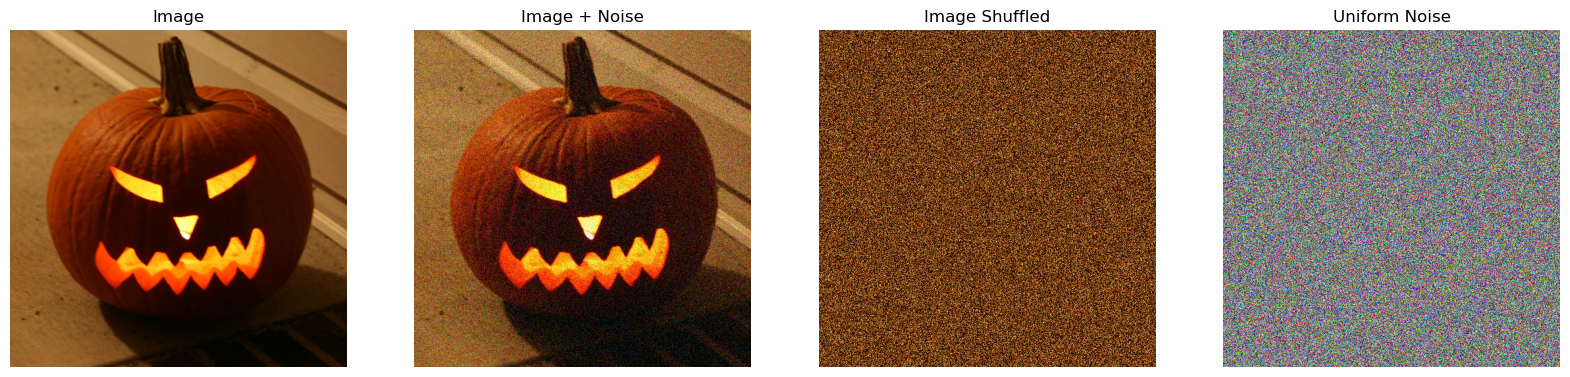

In [2]:
image_path = 'data/jack-o-lantern.jpg'
clean_image = load_image(image_path, target_size=(w, h), tensor=True).to(device) # Load image
noisy_image = add_noise(clean_image, noise_factor=0.1).unsqueeze(0).to(device) # Add noise to image
noise = torch.rand_like(clean_image).uniform_(0, 1).unsqueeze(0).to(device) # Create uniform noise
shuffled = clean_image.view(-1, clean_image.size(1) * clean_image.size(2))
shuffled = shuffled[:, torch.randperm(shuffled.size(1))]# Randomly shuffle image
shuffled = shuffled.view(clean_image.size()).unsqueeze(0).to(device)
clean_image = clean_image.unsqueeze(0)

plot_images([clean_image, noisy_image, shuffled, noise],
           ['Image', 'Image + Noise', 'Image Shuffled', 'Uniform Noise'])

Epoch [0/10000] Loss: 0.391132


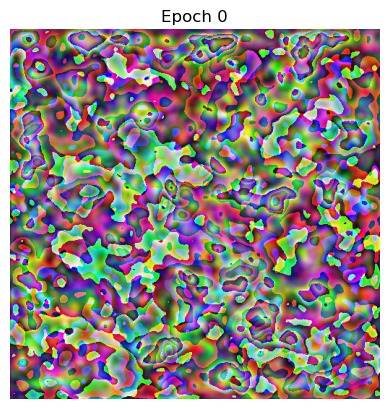

Epoch [1000/10000] Loss: 0.008456


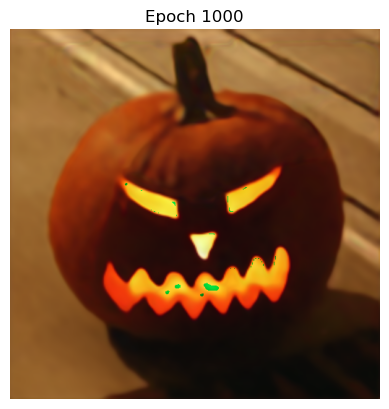

Epoch [2000/10000] Loss: 0.008303


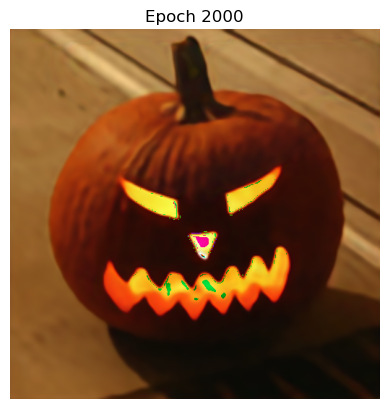

Epoch [3000/10000] Loss: 0.008049


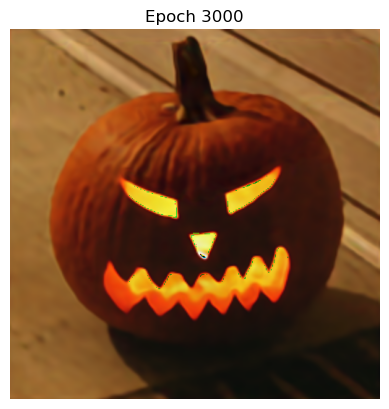

Epoch [4000/10000] Loss: 0.007798


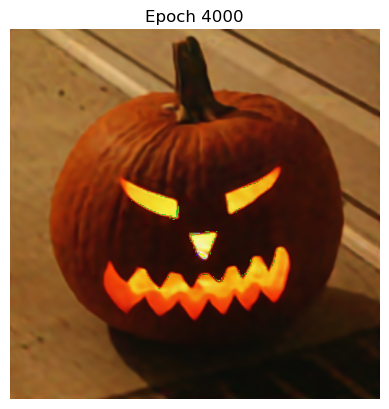

Epoch [5000/10000] Loss: 0.007703


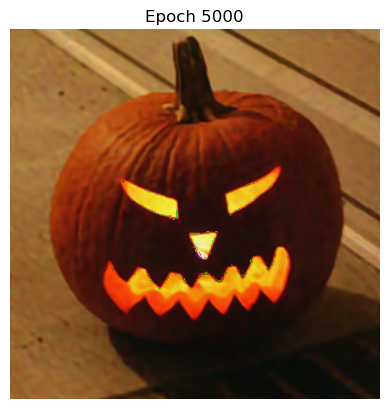

Epoch [6000/10000] Loss: 0.007650


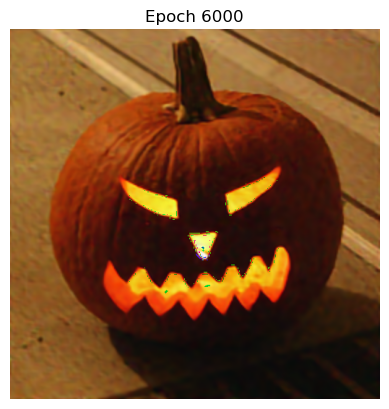

Epoch [7000/10000] Loss: 0.007500


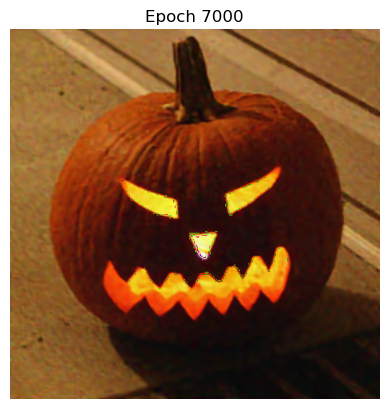

Epoch [8000/10000] Loss: 0.007420


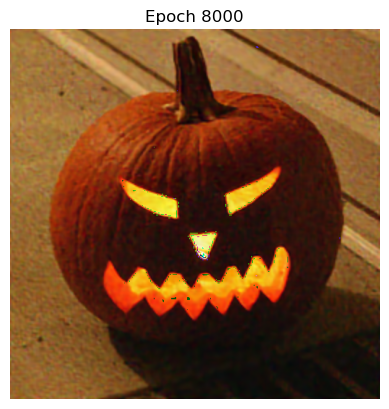

Epoch [9000/10000] Loss: 0.007356


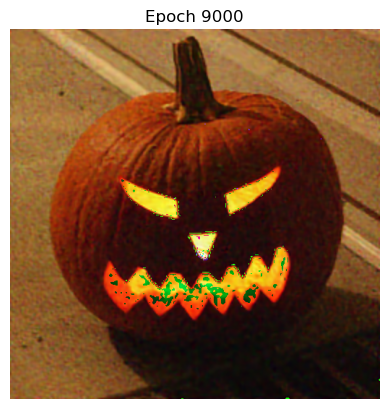

Epoch [9999/10000] Loss: 0.007041


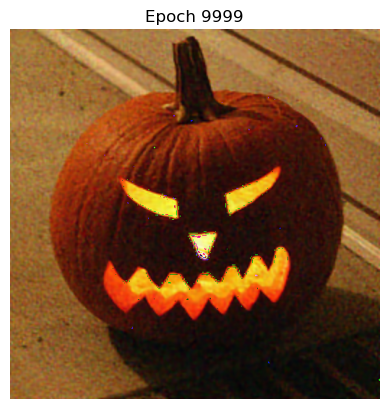

In [5]:
jack_o_lantern_net = train(noisy_image, show_intermediates=True, logging_name='Image + Noise')

The above training process shows effective denoising. The jack-o-lantern can be seen at epoch 5000 to have been reconstructed without the Gaussian noise present in the in the target. It can also be seen that after 10,000 epochs, the image is eventually reconstructed with the noise. This highlights the importance of monitoring and early stopping.  

Below, the network is additionally trained on the original image, the shuffled pixels, and random uniform noise. The plot shows that the network is able to most easily reconstruct the original image, followed by the image with Gaussian noise, and then with much more difficulty the shuffled image, and random noise. This is matches the results that the authors saw with an image of Bill Murray. A reproduction of those specific results is shown below.  

In [6]:
train(clean_image, show_loss=False, logging_name='Image')
train(shuffled, show_loss=False, logging_name='Image Shuffled')
train(noise, show_loss=False, logging_name='Noise')

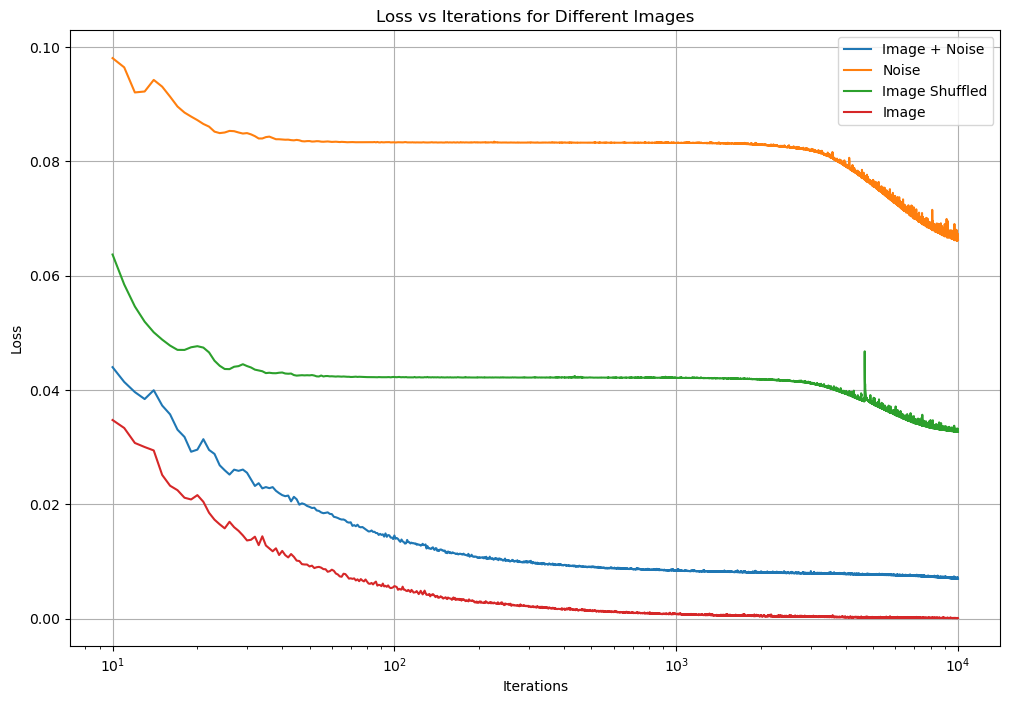

In [9]:
plt.figure(figsize=(12, 8))
for image_name in loss_df.columns:
    plt.plot(loss_df[image_name][10:], label=image_name)

plt.xlabel('Iterations')
plt.xscale('log')
plt.ylabel('Loss')
plt.title('Loss vs Iterations for Different Images')
plt.legend()
plt.grid(True)
plt.show()

# Denoising - Bill Murray

Above is reproduction of the authors findings on a novel image of a jack-o-lantern. To fully confirm the authors findings, the process is repeated below with their image of Bill Murray. The results with the image of Bill Murray match those in Ulyanov et al. and support our results above.

In [ ]:
# Loading images
bill = load_image('data/bill_murray.png', target_size=(w, h), tensor=True).unsqueeze(0).to(device)
bill_noisy = load_image('data/bill_murray_noisy.png', target_size=(w, h), tensor=True).unsqueeze(0).to(device)
bill_shuffled = load_image('data/bill_murray_shuffled.png', target_size=(w, h), tensor=True).unsqueeze(0).to(device)
random_noise = load_image('data/random_noise.png', target_size=(w, h), tensor=True).unsqueeze(0).to(device)

# Training networks for each image
bill_net = train(bill, show_loss=False, logging_name='Bill')
bill_noise_net = train(bill_noisy, show_loss=False, logging_name='Bill + Noise')
bill_shuffled_net = train(bill_shuffled , show_loss=False, logging_name='Bill Shuffled')
bill_random_ net = train(random_noise, show_loss=False, logging_name='Uniform Noise')

# Show images
plot_images([bill, bill_noisy, bill_shuffled, random_noise],
           ['Image', 'Image + Noise', 'Image Shuffled', 'Uniform Noise'])

# Plotting loss
plt.figure(figsize=(12, 8))
for image_name in ['Bill', 'Bill + Noise', 'Bill Shuffled', 'Uniform Noise']:
    plt.plot(loss_df[image_name][10:], label=image_name)
plt.xlabel('Iterations')
plt.xscale('log')
plt.ylabel('Loss')
plt.title('Loss vs Iterations for Different Images')
plt.legend()
plt.grid(True)
plt.show()

# Conclusions

The experiments conducted show a reproduction of the results seen by Ulyanov et al. and support the following findings from that paper:
1. Convolutions neural networks (CNNs) can themselves serve as image priors.
2. Deep Image Prior (DIP) nets can be used for the image reconstruction task of denoising.
3. CNNs (specificaly DIPs) learn natural images more effectively, supporting and explaing their use as priors.